In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import lya_mock_functions as mock

ModuleNotFoundError: No module named 'lya_mock_functions'

In [3]:
#Open data file
hdulist = fits.open('/Users/jfarr/Projects/repixelise/test_input/test_skewers_4096_gaussian_srcs_s0_0.fits')

#Extract redshift from data file
z = hdulist[4].data['Z']
z = np.asarray(z)

In [4]:
#Get number of quasars, and redshift array
N_qso = len(hdulist[1].data['Z_COSMO'])
print('There are %d quasars in the sample.' % N_qso)
z_qso = hdulist[1].data['Z_COSMO']

#Get the length of each skewer.
N_pix_skewer = hdulist[2].data.shape[1]
print('There are %d pixels in each skewer.' % N_pix_skewer)

There are 442460 quasars in the sample.
There are 2048 pixels in each skewer.


In [5]:
#Show the structure of the data
print(hdulist[2].header.keys)

#Get delta (the deviation from average density field) for the highest redshift quasar in the sample.
id = np.argmax(hdulist[1].data['Z_COSMO'])
delta = hdulist[2].data[id]

<bound method Header.iterkeys of XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =               442460 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
CONTENTS= 'density skewers'                                                     >


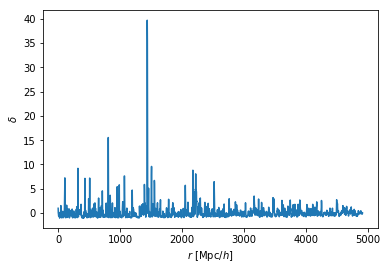

In [6]:
#Show delta vs r
print('mean delta =', np.mean(delta))
print('var delta =', np.var(delta))
plt.figure()
plt.plot(hdulist[4].data['R'],hdulist[2].data[id])
plt.xlabel('$r\\,\\,[{\\rm Mpc}/h]$')
plt.ylabel('$\\delta$')
plt.show()

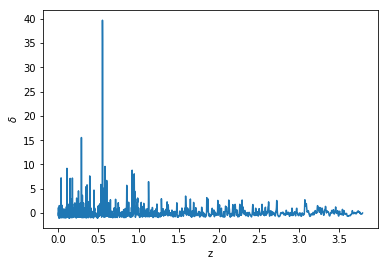

In [7]:
#Show delta vs z
plt.figure()
plt.plot(z,delta)
plt.xlabel('z')
plt.ylabel('$\\delta$')
plt.show()

mean density = 1.13811
var density = 2.92245


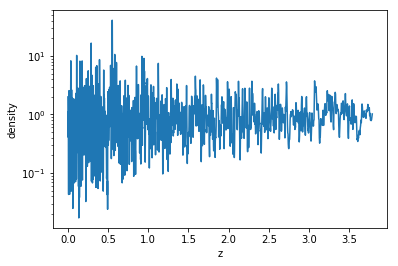

In [8]:
#Show density vs z
density = (delta + 1)
print('mean density =', np.mean(density))
print('var density =', np.var(density))
plt.figure()
plt.semilogy(z,density)
plt.xlabel('z')
plt.ylabel('density')
plt.show()

In [1]:
#Convert from a lognormal density field to optical depth
tau = mock.get_tau(z,density)
print('mean tau =', np.mean(tau))
print('var tau =', np.var(tau))
plt.figure()
plt.semilogy(z,tau)
plt.xlabel('z')
plt.ylabel('optical depth')
plt.show()

NameError: name 'mock' is not defined

In [10]:
#Convert from optical depth to transmitted flux fraction
flux = np.exp(-tau)
print('mean flux =', np.mean(flux))
print('var flux =', np.var(flux))
plt.figure()
plt.plot(z,flux)
plt.xlabel('z')
plt.ylabel('transmitted flux fraction')
plt.show()

NameError: name 'tau' is not defined

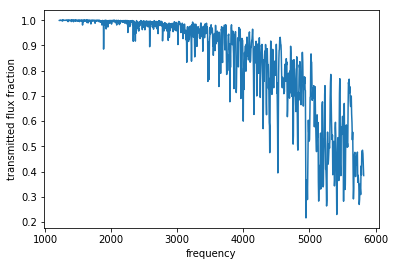

In [10]:
#Show a test skewer spectrum
freq = 1215.67*(1+z)
plt.figure()
plt.plot(freq,flux)
plt.xlabel('frequency')
plt.ylabel('transmitted flux fraction')
plt.show()

In [ ]:
#Calculate density statistics
binned_z, binned_mean_density, binned_density_var, binned_delta_var = mock.density_stats(z,z_qso,(hdulist[2].data)+1)

In [ ]:
#Show the calculated statistics against z
plt.figure()
plot_binned_mean_density = plt.plot(binned_z, binned_mean_density)
plt.xlabel('z')
plt.ylabel('Mean density')
plt.figure()
plot_binned_density_var = plt.plot(binned_z, binned_density_var)
plt.xlabel('z')
plt.ylabel('Density variance')
plt.figure()
plot_binned_delta_var = plt.plot(binned_z, binned_delta_var)
plt.xlabel('z')
plt.ylabel('Delta variance')
print(" ")

In [11]:
#Show a sequence of histograms of delta
#Define redshift bin boundaries: zhb(0)<=z<zhb(1), zhb(1)<=z<zhb(2) etc.
z_hist_bins = [0,2,3]
N_bins = len(z_hist_bins)

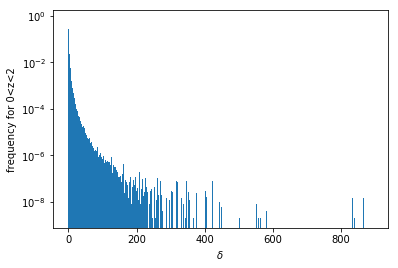

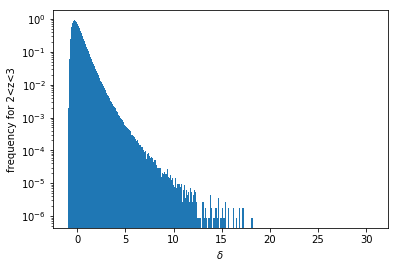

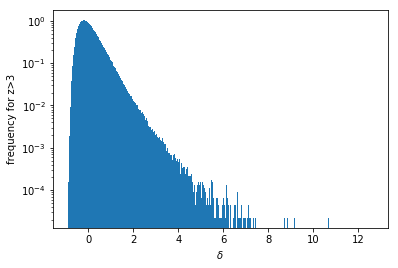

In [16]:
#Show a sequence of histograms of delta
#Define redshift bin boundaries: zhb(0)<=z<zhb(1), zhb(1)<=z<zhb(2) etc.
z_hist_bins_boundaries = [0,2,3]
N_bins = len(z_hist_bins_boundaries)

#For each quasar, set up a mask to remove entries of 0 delta beyond the quasar.
mask = np.ones(hdulist[2].data.shape)
max_pixel_qso = [0.]*N_qso
lower_bound = [0]*N_bins
upper_bound = [0]*N_bins

for j in range(N_qso):
    max_pixel_qso[j] = (np.argmax(z>z_qso[j])-1)%N_pix_skewer
    mask[j,max_pixel_qso[j]+1:]=np.zeros(1,(mask.shape[1]-max_pixel_qso[j]-1))

for i in range(N_bins):
    #get boundaries in skewer length terms
    lower_bound[i] = max(np.argmax(z>z_hist_bins_boundaries[i])-1,0)
    if i+1 < N_bins:
        upper_bound[i] = np.argmax(z>z_hist_bins_boundaries[i+1])-1
    else:
        upper_bound[i] = len(z)-1

    #print histogram
    plt.figure()
    plt.hist(np.ravel(hdulist[2].data[:,lower_bound[i]:upper_bound[i]]),bins=1000,weights=np.ravel(mask[:,lower_bound[i]:upper_bound[i]]),normed=True)
    plt.yscale('log',nonposy='clip')
    plt.xlabel('$\\delta$')
    #y-axis is labelled differently depending on which bin we're looking at.
    if i+1 < N_bins:
        plt.ylabel('frequency for %d<z<%d' % (z_hist_bins_boundaries[i], z_hist_bins_boundaries[i+1]))
    else:
        plt.ylabel('frequency for z>%d' % z_hist_bins_boundaries[i])
        
    plt.show()
